In [41]:
import gpytorch
import matplotlib.pyplot as plt
import torch
from func_data_generation import *
from func_polygon import *
from torch import nn
from utils import *
from warp_units import *

# from torchsummary import summary


dtype = torch.double
device = "cuda" if torch.cuda.is_available() else "cpu"
# device =  "cpu"
print("Using {} device".format(device))

import tqdm

torch.set_default_dtype(dtype)
%matplotlib inline
%load_ext autoreload
%autoreload 2
from datetime import datetime

from torch.utils.tensorboard import SummaryWriter

Using cuda device
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
data_dim = 2


class LargeFeatureExtractor(torch.nn.Sequential):
    def __init__(self):
        super(LargeFeatureExtractor, self).__init__()
        self.add_module("linear1", torch.nn.Linear(data_dim, 1000))
        self.add_module("relu1", torch.nn.ReLU())
        self.add_module("linear2", torch.nn.Linear(1000, 500))
        self.add_module("relu2", torch.nn.ReLU())
        self.add_module("linear3", torch.nn.Linear(500, 50))
        self.add_module("relu3", torch.nn.ReLU())
        self.add_module("linear4", torch.nn.Linear(50, 2))


class QuodralMean(gpytorch.means.Mean):
    def __init__(self):
        super().__init__()
        self.register_parameter(
            name="weights",
            parameter=torch.nn.Parameter(torch.randn(5, 1)),
        )
        self.register_parameter(
            name="bias", parameter=torch.nn.Parameter(torch.randn(1))
        )

    def forward(self, x):
        xx = torch.stack(
            (
                x[:, 0] * x[:, 0],
                x[:, 0] * x[:, 1],
                x[:, 1] * x[:, 1],
                x[:, 0],
                x[:, 1],
            ),
            dim=1,
        )
        res = xx.matmul(self.weights).squeeze(-1)
        return res + self.bias


class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, warp_model):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        #         self.mean_module = QuodralMean()
        self.mean_module = gpytorch.means.ZeroMean()
        #             self.covar_module = gpytorch.kernels.GridInterpolationKernel(
        #                 gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2)),
        #                 num_dims=2, grid_size=100
        #             )
        #         self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

        # SM Kernel
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(
            num_mixtures=4, ard_num_dims=2
        )

        #         self.covar_module2 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        #         self.covar_module2 = (
        #             gpytorch.kernels.LinearKernel() * gpytorch.kernels.LinearKernel()
        #         )
        self.space_transform = warp_model

    def forward(self, x):
        # We're first putting our data through a deep net (feature extractor)
        # We're also scaling the features so that they're nice values
        projected_x = self.space_transform(x)
        projected_x = projected_x - projected_x.min(0)[0]
        projected_x = 2 * (projected_x / projected_x.max(0)[0]) - 1

        mean_x = self.mean_module(x)
        covar_x = self.covar_module(projected_x)  # + self.covar_module2(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [89]:
data_num = 4
sensor_num = 200  # [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

# load data
data_filename = DATA_PATH + "/datasets_" + str(data_num) + ".hd5f"

if os.path.exists(data_filename):
    with h5py.File(data_filename, "r") as f1:
        coords = f1["coords"][...]
        true_rss = f1["true_rss"][...]
        observed_rss = f1["observed_rss"][...]
        train_X = f1["train_" + str(sensor_num) + "/train_X"][...]
        train_y = f1["train_" + str(sensor_num) + "/train_y"][...]
        idx = f1["train_" + str(sensor_num) + "/idx"][...]

In [90]:
result_filename = DATA_PATH + "/result_" + str(data_num) + ".hd5f"
if os.path.exists(result_filename):
    with h5py.File(result_filename, "r") as f2:
        if "free_path" in f2:
            free_path = f2["/free_path/" + str(sensor_num) + "/predict_mean"][...]

observed_rss = observed_rss - free_path
train_y = train_y - free_path[idx]

In [91]:
# Normalize train_X to 0-1
train_X_tensor = torch.from_numpy(train_X).to(device) / 1000
coords_tensor = torch.from_numpy(coords).to(device) / 1000

train_y_tensor = torch.from_numpy(train_y).to(device)
# train_y_mean = train_y_tensor.mean()
# train_y_tensor = train_y_tensor - train_y_mean
# train_y_sigma = torch.sqrt(train_y_tensor.var())
# train_y_tensor = (train_y_tensor - train_y_mean) / train_y_sigma

In [92]:
warp_model = LargeFeatureExtractor().to(device)
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
gp_model = GPRegressionModel(
    train_x=train_X_tensor,
    train_y=train_y_tensor,
    likelihood=likelihood,
    warp_model=warp_model,
).to(device)
gp_model.likelihood.noise = 0.2
# gp_model.covar_module.base_kernel.lengthscale = 0.828
# gp_model.covar_module2.base_kernel.lengthscale = 0.08
# gp_model.covar_module2.outputscale = 46.45

In [93]:
for name, param in gp_model.named_parameters():
    print(f"Layer:{name} | Size:{param.size()} | Values : {param} \n")

Layer:likelihood.noise_covar.raw_noise | Size:torch.Size([1]) | Values : Parameter containing:
tensor([-1.5083], device='cuda:0', requires_grad=True) 

Layer:covar_module.raw_mixture_weights | Size:torch.Size([4]) | Values : Parameter containing:
tensor([0., 0., 0., 0.], device='cuda:0', requires_grad=True) 

Layer:covar_module.raw_mixture_means | Size:torch.Size([4, 1, 2]) | Values : Parameter containing:
tensor([[[0., 0.]],

        [[0., 0.]],

        [[0., 0.]],

        [[0., 0.]]], device='cuda:0', requires_grad=True) 

Layer:covar_module.raw_mixture_scales | Size:torch.Size([4, 1, 2]) | Values : Parameter containing:
tensor([[[0., 0.]],

        [[0., 0.]],

        [[0., 0.]],

        [[0., 0.]]], device='cuda:0', requires_grad=True) 

Layer:space_transform.linear1.weight | Size:torch.Size([1000, 2]) | Values : Parameter containing:
tensor([[-0.5538,  0.4409],
        [-0.1962,  0.2846],
        [-0.3462, -0.3893],
        ...,
        [ 0.2700, -0.1467],
        [ 0.3328,  0

In [94]:
# Use the adam optimizer
optimizer = torch.optim.Adam(
    [
        {"params": gp_model.space_transform.parameters()},
        #         {"params": gp_model.covar_module.raw_outputscale},
        #         {"params": gp_model.covar_module2.parameters(), "lr": 0.1},
        {"params": gp_model.covar_module.parameters()},
        #         {"params": gp_model.mean_module.parameters()},
        #         {"params": gp_model.likelihood.parameters()},
    ],
    lr=0.01,
)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model)


def train():
    iterator = tqdm.notebook.tqdm(range(training_iterations))
    for i, j in enumerate(iterator):
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = gp_model(train_X_tensor)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_y_tensor)
        loss.backward()
        #         iterator.set_postfix(
        #             loss=loss.item(),
        #             output_scale=gp_model.covar_module.outputscale.item(),
        #             leng_scale=gp_model.covar_module.base_kernel.lengthscale.item(),
        #             big_output_scale=gp_model.covar_module2.outputscale.item(),
        #             #             big_leng_scale=gp_model.covar_module2.base_kernel.lengthscale.item(),
        #             noise=gp_model.likelihood.noise.item(),
        #         )
        if i % 10 == 9:
            writer.add_scalar("loss", loss.item(), i)
        #             writer.add_scalar(
        #                 "length_scale1", gp_model.covar_module.base_kernel.lengthscale.item(), i
        #             )
        #             writer.add_scalar(
        #                 "output_scale1", gp_model.covar_module.outputscale.item(), i
        #             )
        #             writer.add_scalar(
        #                 "length_scale",
        #                 gp_model.covar_module2.base_kernel.lengthscale.item(),
        #                 i,
        #             )
        #             writer.add_scalar(
        #                 "output_scale", gp_model.covar_module2.outputscale.item(), i
        #             )
        #         if gp_model.likelihood.noise.item() < 0.2:
        #             break
        optimizer.step()

In [98]:
# gp_model.w1 = 1
# gp_model.w2 = 1

gp_model.train()
likelihood.train()

now = datetime.now()
log_dir = "logs/dgp/" + now.strftime("%Y%m%d-%H%M%S") + "/"
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(log_dir)

training_iterations = 1000
%time train()

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 4min 30s, sys: 4.08 s, total: 4min 34s
Wall time: 12.4 s


In [99]:
# for name, param in gp_model.named_parameters():
#     print(f"Layer:{name} | Size:{param.size()} | Values : {param} \n")
# for name, param in gp_model.named_parameters():
#     print(f"Layer:{name} | Size:{param.size()} | Values : {param} \n"

In [119]:
likelihood.eval()
gp_model.eval()
observed_pred = gp_model(coords_tensor)
mean = observed_pred.mean.detach() + torch.from_numpy(free_path).to(device)
var = observed_pred.variance.detach()

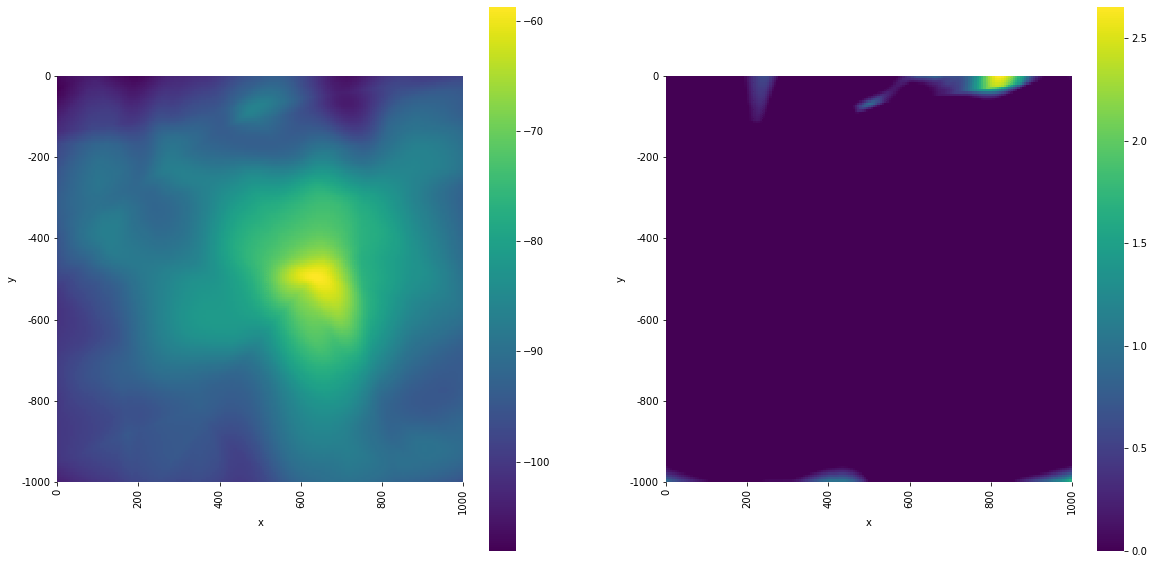

In [120]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plot_heatmap(coords, mean, ax=axes[0], cbar=True)
plot_heatmap(coords, var, ax=axes[1], cbar=True)

In [117]:
save_result("result_4", "dgp", sensor_num, mean.cpu().numpy(), var.cpu().numpy())

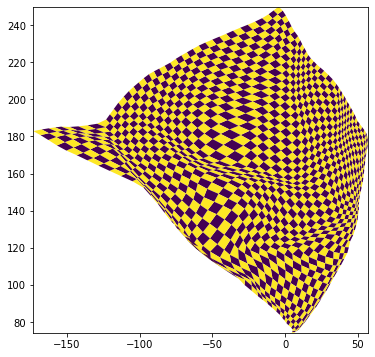

In [77]:
chessboard_from_model(warp_model)

In [109]:
free_path.shape

(32400,)